# Connect to Chinook Database

In [1]:
from sqlalchemy import create_engine, inspect
import pandas as pd

### Connect database Chinook.sqlite

In [2]:
engine = create_engine("sqlite:///Chinook.sqlite")
inspector = inspect(engine)
table_names = inspector.get_table_names()
table_names # Check table names

['Album',
 'Artist',
 'Customer',
 'Employee',
 'Genre',
 'Invoice',
 'InvoiceLine',
 'MediaType',
 'Playlist',
 'PlaylistTrack',
 'Track']

### Check out Queen's artist id

In [3]:
queen_df = pd.read_sql_query("SELECT * FROM Artist WHERE Name = 'Queen'", con=engine)
queen_id = int(queen_df["ArtistId"].values[0])
queen_id

51

### Check out Queen's albums

In [4]:
queen_album = pd.read_sql_query(f"SELECT * FROM Album WHERE ArtistId = {queen_id}", con=engine)
queen_album

,AlbumId,Title,ArtistId
0,36,Greatest Hits II,51
1,185,Greatest Hits I,51
2,186,News Of The World,51


In [5]:
album_id = queen_album["AlbumId"].values
album_id = tuple(map(lambda x: int(x), album_id))
album_id

(36, 185, 186)

### Check out Genre Table

In [6]:
genre_df = pd.read_sql_query("SELECT * FROM Genre", con=engine)
genre_df

,GenreId,Name
0,1,Rock
1,2,Jazz
2,3,Metal
3,4,Alternative & Punk
4,5,Rock And Roll
5,6,Blues
6,7,Latin
7,8,Reggae
8,9,Pop
9,10,Soundtrack


### Check out Queen's tracks

In [7]:
track_df = pd.read_sql_query(f"SELECT * FROM Track WHERE AlbumId IN {album_id}", con=engine)
len(track_df)

45

# Do Web Scraping

In [8]:
import gazpacho as gaz
import requests

In [9]:
url = "https://kworb.net/spotify/artist/1dfeR4HaWDbWqFHLkxsg1d_songs.html"
response = requests.get(url)
response.status_code # 200 means okay

200

In [10]:
txt = gaz.Soup(response.text)
table = txt.find("table")
table = table[1].find("td") # find table and td tag

In [11]:
songs = []
for line in table:
    x = line.find("td")
    if x:
        songs.append(x.strip())

In [12]:
song_clean = []
total_clean = []
daily_clean = []

for i in range(0, len(songs), 3):
    idx = songs[i].find(" - ")
    res1 = songs[i][:idx]
    
    clean_res2 = songs[i+1].split(",")
    res2 = int("".join(clean_res2))
    
    clean_res3 = songs[i+2].split(",")
    res3 = int("".join(clean_res3))
    
    song_clean.append(res1)
    total_clean.append(res2)
    daily_clean.append(res3)
    

In [13]:
len(song_clean) # check len of list

500

In [14]:
list_of_tuples = list(zip(song_clean, total_clean, daily_clean))
df = pd.DataFrame(list_of_tuples, columns=["Name", "Streams", "Daily"])
df[df["Name"] == "Bohemian Rhapsody"]

,Name,Streams,Daily
0,Bohemian Rhapsody,2675274192,819812
42,Bohemian Rhapsody,79618247,12356
80,Bohemian Rhapsody,21756291,5019
95,Bohemian Rhapsody,14101960,3463
139,Bohemian Rhapsody,7931720,1583
187,Bohemian Rhapsody,5066721,520
224,Bohemian Rhapsody,4167550,541
283,Bohemian Rhapsody,2962241,218
289,Bohemian Rhapsody,2900733,491
407,Bohemian Rhapsody,1308131,242


In [15]:
df.iloc[200:]

,Name,Streams,Daily
200,We Will Rock You (Fast),4701501,1077
201,My Life Has Been Saved,4696529,1348
202,Bohemian Rhapsody / Radio Ga Ga,4672553,2553
203,Liar,4613168,252
204,Tear It Up,4607227,856
...,...,...,...
495,Pain Is So Close To Pleasure,766167,144
496,Flash,765439,104
497,Bring Back That Leroy Brown,763380,150
498,Crazy Little Thing Called Love,758127,89


Filter the duplicate name and remain the highest streams column

In [16]:
idx = df.groupby("Name")["Streams"].idxmax()
df_filtered = df.loc[idx]
len(df_filtered)

238

## Data Cleaning

In [50]:
track_full = pd.merge(df_filtered, track_df, on="Name", how="inner")
track_full.head()

,Name,Streams,Daily,TrackId,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,A Kind Of Magic,292238628,148459,419,36,1,1,Roger Taylor,262608,8689618,0.99
1,"All Dead, All Dead",25361437,3982,2274,186,1,1,May,190119,6144878,0.99
2,Another One Bites The Dust,2063942980,817595,2255,185,1,1,"Deacon, John",216946,7172355,0.99
3,Bicycle Race,162489270,40641,2258,185,1,1,"Mercury, Freddie",183823,6012409,0.99
4,Bohemian Rhapsody,2675274192,819812,2254,185,1,1,"Mercury, Freddie",358948,11619868,0.99


In [51]:
composer = list(track_full["Composer"])
clean1 = []
for ele in composer:
    if "/" in ele:
        idx = ele.find("/")
        one = ele[:idx]
        two = ele[idx+1:]
        
        if ", " in one and ", " in two:
            res1 = one.split(", ")
            one = " ".join(res1)
            
            res2 = one.split(", ")
            two = " ".join(res2)
        
        if one != two:  
            clean1.append(one + " & " + two)
        else:
            clean1.append(one)
    else:
        clean1.append(ele)

In [52]:
clean1

['Roger Taylor',
 'May',
 'Deacon, John',
 'Mercury, Freddie',
 'Mercury, Freddie',
 'Queen',
 'Mercury, Freddie',
 'Mercury, Freddie',
 'May, Brian',
 'Taylor',
 'May, Brian',
 'Freddie Mercury & John Deacon',
 'Mercury',
 'Mercury, Freddie',
 'Brian May',
 'Queen',
 'Queen',
 'John Deacon',
 'Queen',
 'Queen',
 'Freddie Mercury',
 'May',
 'Mercury, Freddie',
 'Mercury',
 'May, Brian',
 'Queen',
 'Mercury, Freddie',
 'May, Brian',
 'Mercury, Freddie',
 'Taylor',
 'Mercury, Freddie',
 'Deacon',
 'Queen',
 'Queen',
 'Queen',
 'Queen & David Bowie',
 'Mercury, Freddie',
 'Mercury',
 'Deacon John',
 'May',
 'Deacon',
 'Brian May',
 'Deacon, John']

In [53]:
clean2 = []
for ele in clean1:
    if "&" in ele:
         clean2.append(ele)
    else:   
        if "Taylor" in ele or "Roger" in ele:
            clean2.append("Roger Taylor")
        elif "May" in ele or "Brian" in ele:
            clean2.append("Brian May")
        elif "John" in ele or "Deacon" in ele:
            clean2.append("John Deacon")
        else:
            clean2.append("Freddie Mercury")
            person = "Freddie Mercury"

In [55]:
clean_df = pd.DataFrame({"Clean_composer":clean2})

In [56]:
track_full["Clean_composer"] = clean_df
track_full = track_full.drop("Composer", axis=1)
track_full = track_full.rename(columns={"Clean_composer":"Composer"})
track_full.head()

,Name,Streams,Daily,TrackId,AlbumId,MediaTypeId,GenreId,Milliseconds,Bytes,UnitPrice,Composer
0,A Kind Of Magic,292238628,148459,419,36,1,1,262608,8689618,0.99,Roger Taylor
1,"All Dead, All Dead",25361437,3982,2274,186,1,1,190119,6144878,0.99,Brian May
2,Another One Bites The Dust,2063942980,817595,2255,185,1,1,216946,7172355,0.99,John Deacon
3,Bicycle Race,162489270,40641,2258,185,1,1,183823,6012409,0.99,Freddie Mercury
4,Bohemian Rhapsody,2675274192,819812,2254,185,1,1,358948,11619868,0.99,Freddie Mercury


# Data analysis and Visualization

In [22]:
import matplotlib.pyplot as plt
import numpy as np

## Sum of Total Streams by album

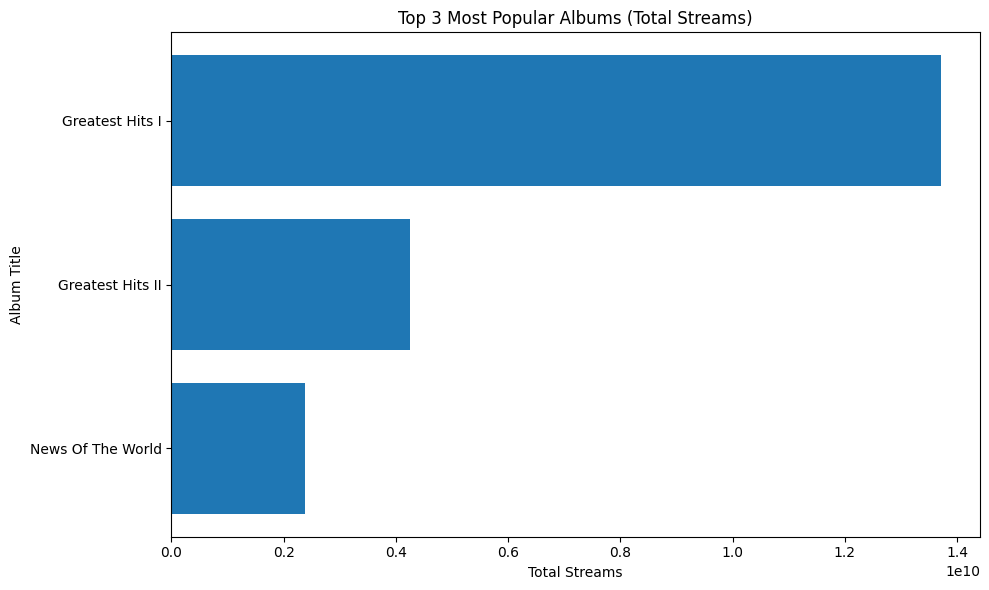

In [31]:
album_hit = track_full.groupby("AlbumId")["Streams"].sum()
album_hit_df = pd.merge(queen_album, album_hit, on="AlbumId", how="inner").sort_values("Streams")

plt.figure(figsize=(10, 6))
plt.barh(album_hit_df["Title"], album_hit_df["Streams"])
plt.subplots_adjust(left=0.3)

plt.ylabel("Album Title")
plt.xlabel("Total Streams")
plt.title("Top 3 Most Popular Albums (Total Streams)")

plt.tight_layout()
plt.show()

## Top 10 Most Popular Songs

In [24]:
song_hit = track_full.sort_values(by="Streams", ascending=False)
song_hit = song_hit.iloc[:10][["Name", "Streams", "Daily"]]
song_hit

,Name,Streams,Daily
4,Bohemian Rhapsody,2675274192,819812
7,Don't Stop Me Now,2200566686,979838
2,Another One Bites The Dust,2063942980,817595
35,Under Pressure,1779255021,770943
38,We Will Rock You,1442065328,547185
39,We Will Rock You,1442065328,547185
6,Crazy Little Thing Called Love,1034581179,561987
30,Somebody To Love,955183008,313256
22,Killer Queen,929750759,359533
36,We Are The Champions,773235534,248829


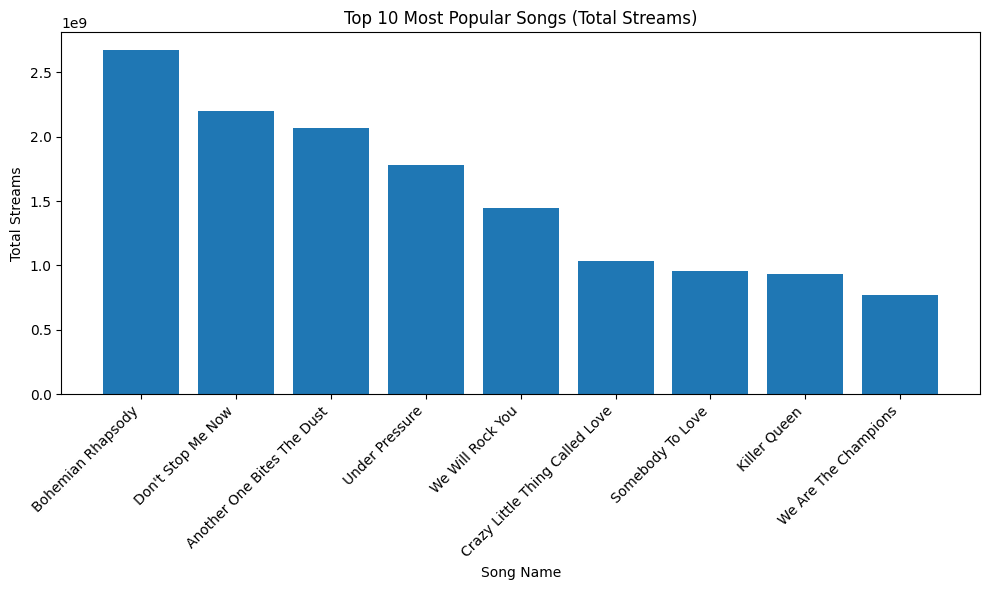

In [25]:
plt.figure(figsize=(10, 6))
plt.bar(song_hit["Name"], song_hit["Streams"])

plt.xlabel("Song Name")
plt.ylabel("Total Streams")
plt.title("Top 10 Most Popular Songs (Total Streams)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

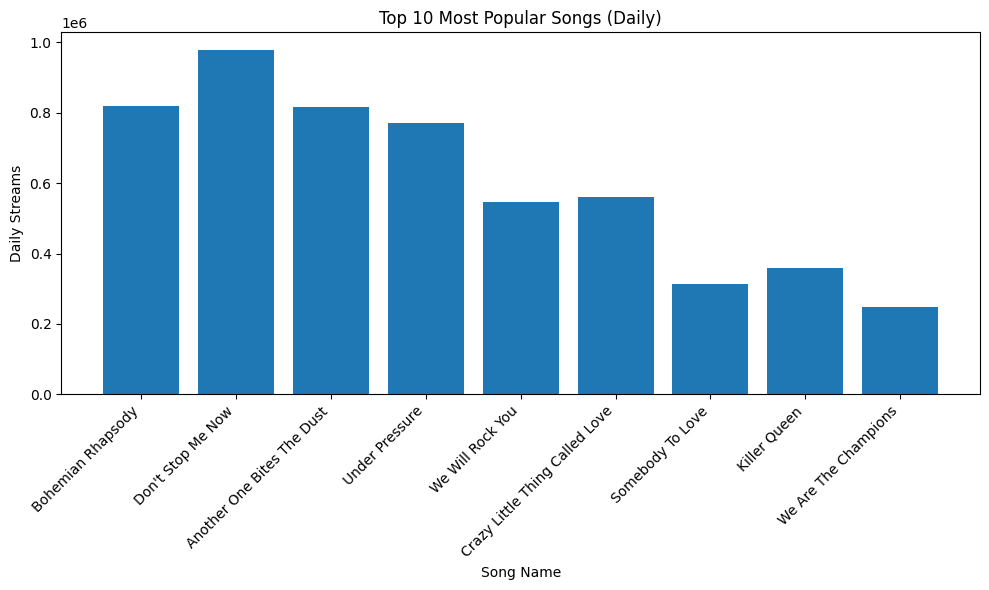

In [26]:
# Restart kernel for lastest update
plt.figure(figsize=(10, 6))
plt.bar(song_hit["Name"], song_hit["Daily"])

plt.xlabel("Song Name")
plt.ylabel("Daily Streams")
plt.title("Top 10 Most Popular Songs (Daily)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

## Length of Top 10 Most Popular Songs

In [27]:
song_hit = track_full.sort_values(by="Streams", ascending=False)
hit_calculation = song_hit[["Name", "Milliseconds"]].iloc[:10]
hit_calculation["Minute"] = round(hit_calculation["Milliseconds"] / (1000 * 60.0), 2)
hit_calculation

,Name,Milliseconds,Minute
4,Bohemian Rhapsody,358948,5.98
7,Don't Stop Me Now,211826,3.53
2,Another One Bites The Dust,216946,3.62
35,Under Pressure,236617,3.94
38,We Will Rock You,122880,2.05
39,We Will Rock You,122671,2.04
6,Crazy Little Thing Called Love,164231,2.74
30,Somebody To Love,297351,4.96
22,Killer Queen,182099,3.03
36,We Are The Champions,180950,3.02


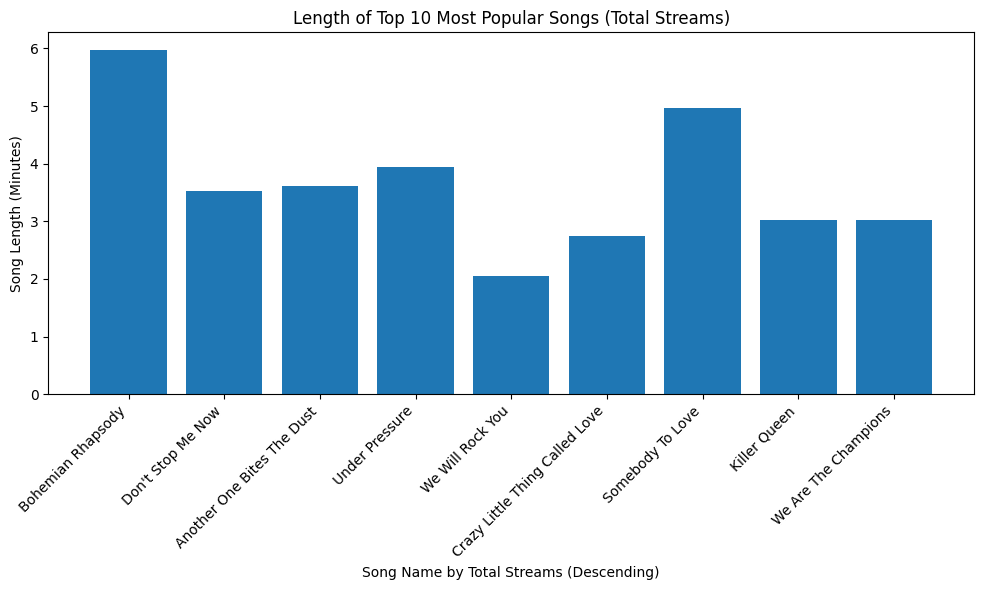

In [28]:
plt.figure(figsize=(10, 6))
plt.bar(hit_calculation['Name'], hit_calculation['Minute'])

plt.xlabel('Song Name by Total Streams (Descending)')
plt.ylabel('Song Length (Minutes)')
plt.title('Length of Top 10 Most Popular Songs (Total Streams)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Genre of Songs

In [29]:
queen_genre = pd.merge(track_full, genre_df, on="GenreId", how="left")
queen_genre.rename(columns={"Name_x": "Name", "Name_y":"Genre"}, inplace=True)
queen_genre = queen_genre["Genre"].value_counts(normalize=True)
qg = queen_genre.values[0]
qg = float(qg)
qg

1.0

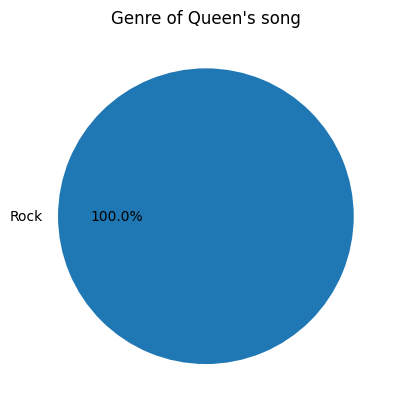

In [30]:
y = np.array([qg])
mylabels = ["Rock"]

plt.pie(y, labels = mylabels, autopct="%1.1f%%")
plt.title("Genre of Queen's song")
plt.show()

## Percentage of Composers

In [57]:
com_df = track_full.groupby("Composer")["TrackId"].count()
percent = np.array(com_df.values)
mylabels = np.array(com_df.index.values)

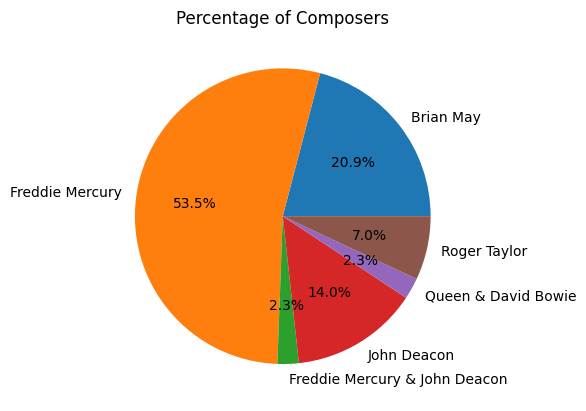

In [58]:
plt.pie(percent, labels = mylabels, autopct="%1.1f%%")
plt.title("Percentage of Composers")
plt.show()